In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import geo
import utils

# set device and load models
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

gm, gm_opt, gm_loss_hist = utils.load_model("gmvae_20230221_014308.pt", "gmvae", {"input_dim": 2766, "latent_dim": 2, "num_clusters": 5}, dev)
vae, vae_opt, vae_loss_hist = utils.load_model("vae_20230221_014308.pt", "vae", {"input_dim": 2766, "latent_dim": 2}, dev)

In [3]:
from geo import compute_length_of_curve, get_Riemannian_metric

# compute the length of two crossing curves in latent space
curve1 = torch.tensor([[-2, -2], [-1.5, -1.5], [-1, -1], [-0.5, -0.5], [0, 0], [0.5, 0.5], [1, 1], [1.5, 1.5], [2, 2]]).to(dev)
curve2 = torch.tensor([[-2, 2], ## compute the geodesic between two points in latent space
[-1.5, 1.5], [-1, 1], [-0.5, 0.5], [0, 0], [0.5, -0.5], [1, -1], [1.5, -1.5], [2, -2]]).to(dev)

vae_len1 = compute_length_of_curve(curve1, vae.decode, get_Riemannian_metric).item()
vae_len2 = compute_length_of_curve(curve2, vae.decode, get_Riemannian_metric).item()

gm_len1 = compute_length_of_curve(curve1, gm.decode, get_Riemannian_metric).item()
gm_len2 = compute_length_of_curve(curve2, gm.decode, get_Riemannian_metric).item()

print("  VAE: %f, %f" % (vae_len1, vae_len2))
print("GMVAE: %f, %f" % (gm_len1, gm_len2))

  VAE: 336.583252, 456.003662
GMVAE: 162.408310, 130.855530


In [4]:
# load the data
test_loader = utils.create_dataloader("celegan", 8192, shuffle=False)
test = test_loader.dataset.data.to(dev)
print("Test data shape: %s" % str(test.shape))

# compute the latent representations 
gm.eval()
vae.eval()

gm_latent = gm.reparameterize(*gm.encode(test), temperature=0.5)[0].detach().cpu().numpy()
vae_latent = vae.encode(test)[0].detach().cpu().numpy()
print("Latent representations shape: %s" % str(gm_latent.shape))

torch.Size([86024, 2766])


In [57]:
# helpers for picking interesting latent points 
def get_index(latent, threshold=500):
    return np.where(np.abs(latent[:, 1]) > threshold)[0]

def get_i_over(latent, threshold=500):
    return np.where(latent[:, 1] > threshold)[0]

def get_i_under(latent, threshold=-500):
    return np.where(latent[:, 1] < threshold)[0]

# get the latent points
gm_subset_over = gm_latent[get_i_over(gm_latent, 500)]
gm_subset_under = gm_latent[get_i_under(gm_latent, -500)]

vae_subset_over = vae_latent[get_i_over(vae_latent, 3.5)]
vae_subset_under = vae_latent[get_i_under(vae_latent, -15)]

gm_p1, gm_p2 = gm_subset_over[0], gm_subset_under[0]
vae_p1, vae_p2 = vae_subset_over[0], vae_subset_under[0]

# cast to torch and unsqueeze
gm_p1, gm_p2 = torch.tensor(gm_p1).unsqueeze(0), torch.tensor(gm_p2).unsqueeze(0)
vae_p1, vae_p2 = torch.tensor(vae_p1).unsqueeze(0), torch.tensor(vae_p2).unsqueeze(0)

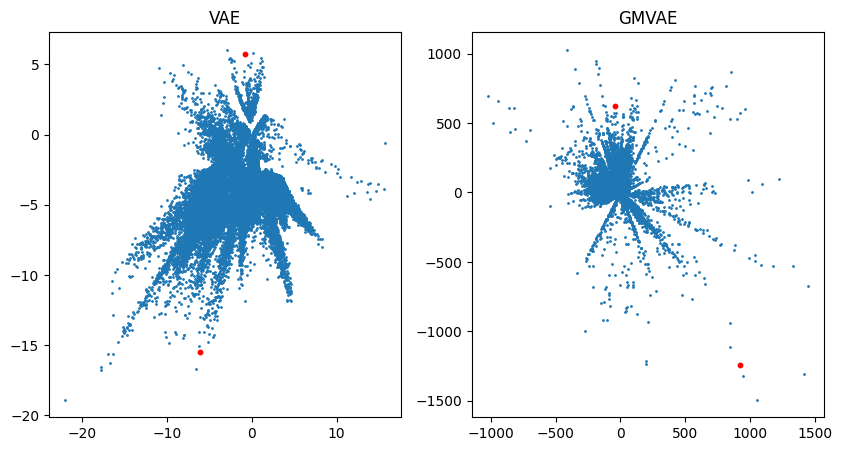

In [53]:
# plot the latent space and chosen points 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(vae_latent[:, 0], vae_latent[:, 1], s=1)
plt.scatter(vae_p1[0], vae_p1[1], c="red", s=10)
plt.scatter(vae_p2[0], vae_p2[1], c="red", s=10)
plt.title("VAE")
plt.subplot(1, 2, 2)
plt.scatter(gm_latent[:, 0], gm_latent[:, 1], s=1)
plt.scatter(gm_p1[0], gm_p1[1], c="red", s=10)
plt.scatter(gm_p2[0], gm_p2[1], c="red", s=10)
plt.title("GMVAE")
plt.show()

/home/ndy/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:550: RuntimeWarning: Method Powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


Optimization terminated successfully.
         Current function value: 199.507843
         Iterations: 5
         Function evaluations: 3187
   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
  

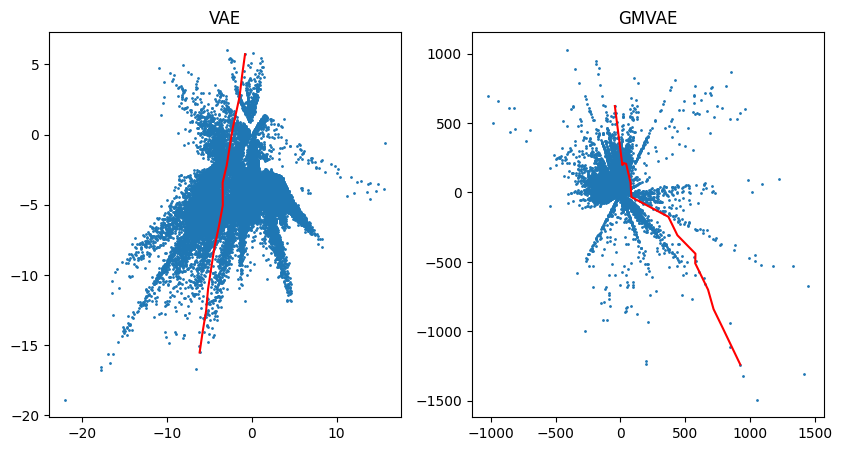

In [71]:
# ---------------------------------------------------------
# compute the geodesic between two points in latent space - 
# ---------------------------------------------------------

# lambda function which takes x and returns torch.tensor(x): 
# t = lambda x: torch.tensor(x)

# # get the latent space coordinates of the two points
# i1, i2 = 0, 1500
# p1_vae = t(vae_latent[i1:i1+1])
# p2_vae = t(vae_latent[i2:i2+1])

# p1_gm = t(gm_latent[i1:i1+1])
# p2_gm = t(gm_latent[i2:i2+1])

# compute the geodesic
curve_vae = geo.compute_geodesic(vae_p1, vae_p2, vae.decode, get_Riemannian_metric, 15, dev)
curve_gm = geo.compute_geodesic(gm_p1, gm_p2, gm.decode, get_Riemannian_metric, 15, dev)

# plot the geodesic
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(vae_latent[:, 0], vae_latent[:, 1], s=1)
plt.plot(curve_vae[:, 0], curve_vae[:, 1], c="r")
plt.title("VAE")
plt.subplot(1, 2, 2)
plt.scatter(gm_latent[:, 0], gm_latent[:, 1], s=1)
plt.plot(curve_gm[:, 0], curve_gm[:, 1], c="r")
plt.title("GMVAE")
plt.show()

In [77]:
len1 = geo.compute_length_of_curve(curve_gm, gm.decode, get_Riemannian_metric)

gm_linear = geo.compute_linear(gm_p1, gm_p2, 15, dev)
len2 = geo.compute_length_of_curve(gm_linear, gm.decode, get_Riemannian_metric)

len1, len2

(tensor(6155.5840), tensor(11150.1865))

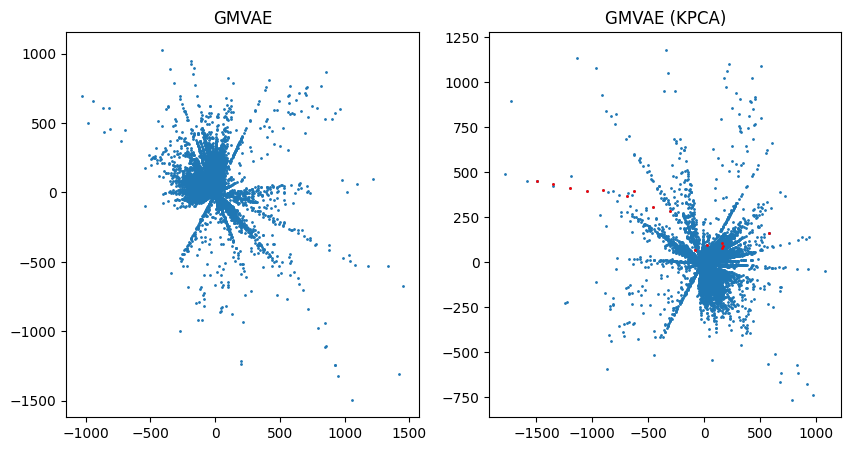

In [85]:
# do a kernel PCA on the latent space of the GMVAE
from sklearn.decomposition import KernelPCA, IncrementalPCA

# add the curve to the latent space
gm_latent2 = np.concatenate((gm_latent, curve_gm), axis=0)

# do the kernel PCA
# pca = KernelPCA(n_components=2, kernel="cosine") #kernel="rbf", gamma=0.1) # RUNS OUT OF MEMORY
pca = IncrementalPCA(n_components=2)
gm_reduced = pca.fit_transform(gm_latent2)

# plot the latent space and the projection
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(gm_latent2[:, 0], gm_latent2[:, 1], s=1)
plt.title("GMVAE latent space")
plt.subplot(1, 2, 2)
plt.scatter(gm_reduced[:, 0], gm_reduced[:, 1], s=1)
curve_indices = np.arange(gm_latent.shape[0], gm_latent2.shape[0])
plt.scatter(gm_reduced[curve_indices, 0], gm_reduced[curve_indices, 1], c="red", s=1)
plt.title("PCA projection")
plt.show()


In [86]:
# Do the same with UMAP projection
import umap

# do the UMAP projection
umap_proj = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, metric="cosine")
gm_reduced_umap = umap_proj.fit_transform(gm_latent2)

# plot the latent space and the projection
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(gm_latent2[:, 0], gm_latent2[:, 1], s=1)
plt.title("GMVAE")
plt.subplot(1, 2, 2)
# plot the projection but color the curve differently
plt.scatter(gm_reduced_umap[:, 0], gm_reduced_umap[:, 1], s=1)

# get the indices of the curve
curve_indices = np.arange(gm_latent.shape[0], gm_latent2.shape[0])
plt.scatter(gm_reduced_umap[curve_indices, 0], gm_reduced_umap[curve_indices, 1], c="red", s=1)
plt.title("GMVAE (UMAP)")
plt.show()


2023-02-21 15:49:09.971533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 15:49:10.377286: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-21 15:49:10.377322: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-21 15:49:12.313865: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

: 

: 

In [ ]:
array([   14.71031269,   197.63579735,    25.88462149,   211.41635415,
          44.1873968 ,   205.92627302,    77.80440847,    73.19021455,
          85.18867663,   -33.28156676,   370.58931791,  -175.10994537,
         440.16540868,  -308.01346877,   579.50205827,  -440.68403345,
         577.5787159 ,  -509.35148438,   676.65675566,  -699.40313794,
         719.26662644,  -839.64072506,   790.32032111,  -975.64089897,
         857.84957661, -1106.9306746 ])
